In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [86]:
import numpy as np
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.palettes import Pastel1
from bokeh.models import Span

<Axes: >

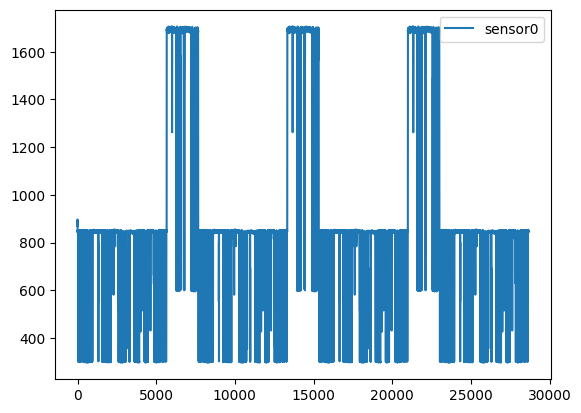

In [95]:
df_nodrift = pd.read_csv(r"C:\Users\franc\Desktop\TESI\training_info\sensors_data.csv")
df_drift = pd.read_csv(r"C:\Users\franc\Desktop\TESI\SML_thesis_line_follower_robot\tmp\e-puck\data\data\sensors_data\sensors_data_drift.csv")
df = pd.DataFrame(df_nodrift)
for i in range(3):
    df = pd.concat([df,df_drift],ignore_index=True)
    df = pd.concat([df,df_nodrift],ignore_index=True)

df.plot(y='sensor0')


Anomalie persistenti rilevate (inizio, fine): []


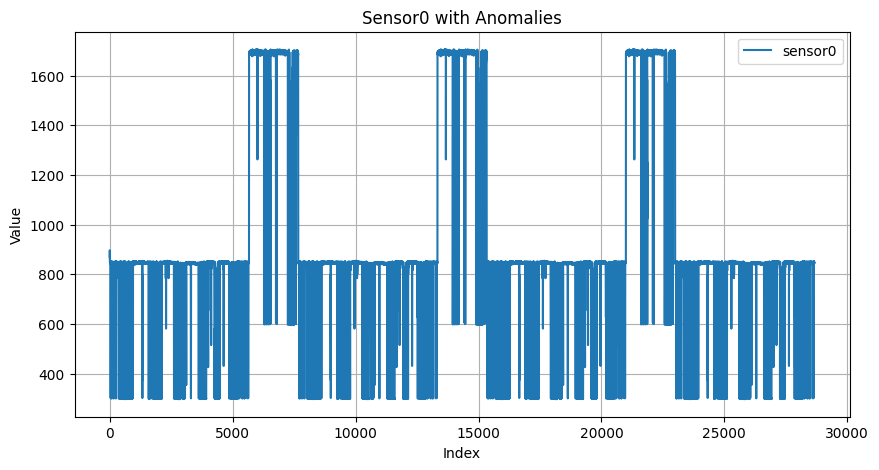

In [125]:

def detect_drift_sequential(nero, bianco, tol, min_duration, min_gap,value):
        anomalies = []
        outlier_count = 0
        anomaly_start = None
        last_anomaly_end = -1
        current_index = 0
        if (value < (nero - tol)) or ((value > (nero + tol)) and (value < (bianco - tol))) or (value > (bianco + tol)):
            outlier_count += 1
            if outlier_count == min_duration:
                anomaly_start = current_index - min_duration + 1
        else:
            if anomaly_start is not None:
                if anomalies and anomaly_start <= last_anomaly_end + min_gap:
                    anomalies[-1] = (anomalies[-1][0], current_index - 1)
                else:
                    anomalies.append((anomaly_start, current_index - 1))
                last_anomaly_end = current_index - 1
                anomaly_start = None
            outlier_count = 0

        current_index += 1
        return anomalies, outlier_count, anomaly_start, last_anomaly_end, current_index



# Uso della funzione
valore_nero = 300
valore_bianco = 850
tolleranza = 50
min_outlier_duration = 20
min_gap_duration = 25



# Elaborazione sequenziale dei dati
for value in df['sensor0'].values:
    anomalies, outlier_count, anomaly_start, last_anomaly_end, current_index = detect_drift_sequential(valore_nero, valore_bianco, tolleranza, min_outlier_duration, min_gap_duration,value)

print("Anomalie persistenti rilevate (inizio, fine):", anomalies)



# Il resto del codice per la visualizzazione rimane invariato
plt.figure(figsize=(10, 5))
plt.plot(df['sensor0'], label='sensor0')
for start, end in anomalies:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Anomaly' if start == anomalies[0][0] else '')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sensor0 with Anomalies')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
def detect_drift(data, nero, bianco, tol, min_duration, min_gap):
    anomalies = []
    outlier_count = 0
    anomaly_start = None
    
    for i in range(len(data)):
        if (data[i] < (nero - tol)) or ((data[i] > (nero + tol)) and (data[i] < (bianco - tol))) or (data[i] > (bianco + tol)):
            outlier_count += 1
            if outlier_count == min_duration:
                anomaly_start = i - min_duration + 1
        else:
            if anomaly_start is not None:
                if anomalies and anomaly_start <= anomalies[-1][1]:
                    anomalies[-1] = (anomalies[-1][0], i - 1)
                else:
                    anomalies.append((anomaly_start, i - 1))
                anomaly_start = None
            outlier_count = 0
    
    # Check if there's an ongoing anomaly at the end of the data
    if anomaly_start is not None:
        if anomalies and anomaly_start <= anomalies[-1][1]:
            anomalies[-1] = (anomalies[-1][0], len(data) - 1)
        else:
            anomalies.append((anomaly_start, len(data) - 1))
    
    # Merge anomalies if the gap between them is less than min_gap
    merged_anomalies = []
    for start, end in anomalies:
        if merged_anomalies and start - merged_anomalies[-1][1] <= min_gap:
            merged_anomalies[-1] = (merged_anomalies[-1][0], end)
        else:
            merged_anomalies.append((start, end))
    
    return merged_anomalies

Anomalie persistenti rilevate (inizio, fine): [(5665, 7664), (13330, 15329), (20995, 22994)]


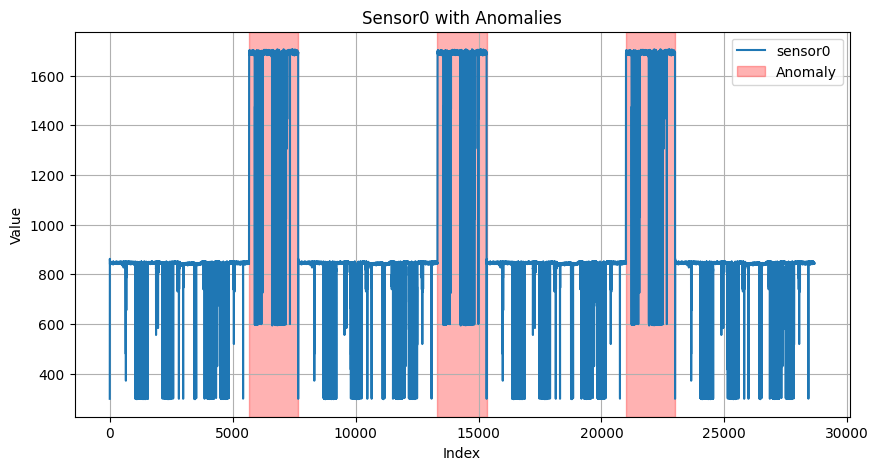

In [113]:

valore_nero = 300
valore_bianco = 850
tolleranza = 50
min_outlier_duration = 20
min_gap_duration = 25

### TODO I DATI ARRIVANO IN MODO SEQUENZIALE

anomalies = detect_drift(df['sensor0'].values, valore_nero, valore_bianco, tolleranza, min_outlier_duration, min_gap_duration)

print("Anomalie persistenti rilevate (inizio, fine):", anomalies)

plt.figure(figsize=(10, 5))
plt.plot(df['sensor2'], label='sensor0')
for start, end in anomalies:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Anomaly' if start == anomalies[0][0] else '')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sensor0 with Anomalies')
plt.legend()
plt.grid(True)
plt.show()